<a href="https://colab.research.google.com/github/Jass1313c/comp215/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime, json, requests
from pprint import pprint

param = { "format": "geojson", "starttime": "2024-03-10","limit": 20000, "endtime": "2024-05-30"}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
response = requests.get(url, params=param)
data = json.loads(response.text)

pprint(data)

for feature in data['features']:
  depth = feature['geometry']['coordinates'][2]
  if depth < 10 and "Texas" in feature['properties']['place']:
    Latitude = feature['geometry']['coordinates'][1]
    Longitude = feature['geometry']['coordinates'][0]
    print(f"Mag: {feature['properties']['mag']},   Place: {feature['properties']['place']},   Time: {datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000)},   Lat: {Latitude},   Long: {Longitude}")

Streaming output truncated to the last 5000 lines.
                            'type': 'Point'},
               'id': 'nn00876333',
               'properties': {'alert': None,
                              'cdi': None,
                              'code': '00876333',
                              'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=nn00876333&format=geojson',
                              'dmin': 0.032,
                              'felt': None,
                              'gap': 130.35000000000002,
                              'ids': ',nn00876333,',
                              'mag': -0.3,
                              'magType': 'ml',
                              'mmi': None,
                              'net': 'nn',
                              'nst': 6,
                              'place': '47 km WNW of Indian Springs, Nevada',
                              'rms': 0.0434,
                              'sig': 0,
                          

In [1]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TypeError: 'Earthquake' object is not subscriptable

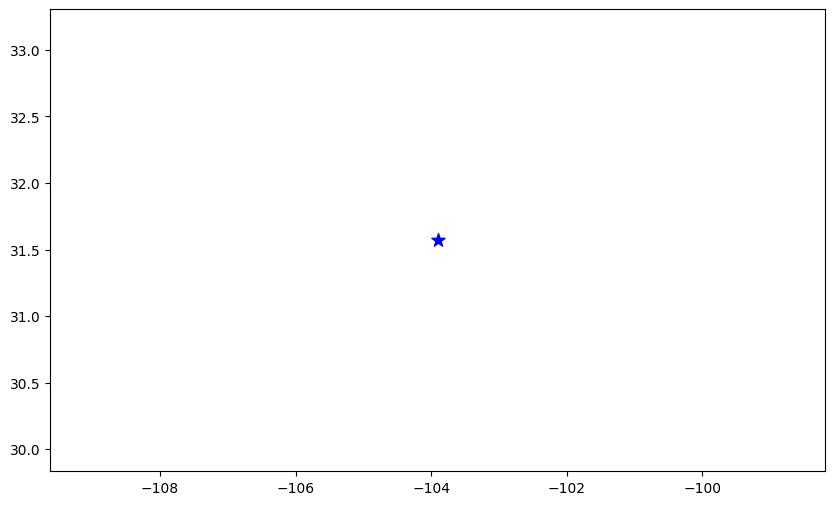

In [66]:
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Fracking site coordinates
frac_site = (31.569435, -103.89977)  # Reeves County

# Function to calculate distance
def distance(point1, point2):
    return geodesic(point1, point2).kilometers

# Create figure and axes
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot fracking site
ax.scatter(frac_site[1], frac_site[0], color='blue', marker='*', s=100, label='Fracking Site (Reeves County)')

# Plot earthquakes within 30km radius
for eq in earthquake_data:
    eq_coords = (eq['Lat'], eq['Long'])
    if distance(frac_site, eq_coords) <= 10:
        ax.scatter(eq['Long'], eq['Lat'], color='red', marker='o', s=20, label='Earthquake (within 30km)')

# Customize plot
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Fracking Site (Reeves County) and Earthquakes within 30km Radius')
ax.grid(True)

# Adjust legend to avoid duplicate labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, loc='best')

plt.show()

In [ ]:
fracking_date = fracking_df['JobStartDate'].iloc[0]
window = 5
# Calculate the start and end of the window
window_start = fracking_date - datetime.timedelta(days=1)
window_end = fracking_date + datetime.timedelta(days=window - 1)

# Print the results
print(f"Fracking Date: {fracking_date}")
print(f"Window Start: {window_start}")
print(f"Window End: {window_end}")

Fracking Date: 2025-01-02 00:00:00
Window Start: 2025-01-01 00:00:00
Window End: 2025-01-06 00:00:00


In [52]:
import pandas as pd
import datetime
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import pyproj #Import the pyproj module for coordinate transformations

# Load fracking data (replace with your actual file path)
file_path = '/content/drive/MyDrive/Fracking.csv'
fracking_df = pd.read_csv(file_path)

# Assuming 'earthquake_data' is already loaded (from previous code)

#Converting coordinate systems to WGS84
source_crs = 'epsg:4269'  # NAD83
target_crs = 'epsg:4326'  # WGS84

pd.set_option('display.max_rows', None)

transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

fracking_df['Latitude_WGS84'], fracking_df['Longitude_WGS84'] = transformer.transform(fracking_df['Latitude'].values, fracking_df['Longitude'].values)

#convert jobstart date into datetime object
fracking_df['JobStartDate'] = pd.to_datetime(fracking_df['JobStartDate'])

#convert jobend date into datetime object
fracking_df['JobEndDate'] = pd.to_datetime(fracking_df['JobEndDate'])


# Spatial and temporal correlation analysis
radius_km = 20  # Set the radius for spatial proximity
time_window_days = 80  # Set the time window for temporal proximity

potentially_induced_earthquakes = []
c = 0
for eq in earthquake_data:
    for index, frac_site in fracking_df.iterrows():

        frac_coords = (frac_site['Latitude_WGS84'], frac_site['Longitude_WGS84'])
        eq_coords = (eq['Lat'], eq['Long'])
        distance = geodesic(frac_coords, eq_coords).kilometers
        if distance <= radius_km:
            # Temporal check: Check if within time window
            frac_start_date = frac_site['JobStartDate']
            frac_end_date = frac_site['JobEndDate']
            eq_time = eq['Time']
            if frac_start_date - datetime.timedelta(days=1) <= eq_time <= frac_start_date + datetime.timedelta(days=time_window_days - 1):
              potentially_induced_earthquakes.append(eq)
              c += 1
              break  # Move to the next earthquake if found near a site within the time window
print(c)
# Visualization: Plotting potentially induced earthquakes
frac_lats = fracking_df['Latitude_WGS84'].tolist()
frac_lons = fracking_df['Longitude_WGS84'].tolist()

induced_eq_lats = [eq['Lat'] for eq in potentially_induced_earthquakes]
induced_eq_lons = [eq['Long'] for eq in potentially_induced_earthquakes]

plt.figure(figsize=(10, 6))
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')
plt.scatter(induced_eq_lons, induced_eq_lats, color='red', label='Potentially Induced Earthquakes similar timing')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking Sites and Potentially Induced Earthquakes')
plt.grid(True)
plt.legend()
plt.show()

<ipython-input-52-0c8aa9a2c345>:24: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-52-0c8aa9a2c345>:27: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



TypeError: 'Earthquake' object is not subscriptable

In [51]:
import pandas as pd
import datetime
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Load fracking data (replace with your actual file path)
file_path = '/content/drive/MyDrive/Fracking.csv'
fracking_df = pd.read_csv(file_path)

# Assuming 'earthquake_data' is already loaded (from previous code)
#Converting coordinate systems to WGS84
source_crs = 'epsg:4269'  # NAD83
target_crs = 'epsg:4326'  # WGS84

pd.set_option('display.max_rows', None)

transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

fracking_df['Latitude_WGS84'], fracking_df['Longitude_WGS84'] = transformer.transform(fracking_df['Latitude'].values, fracking_df['Longitude'].values)

#convert jobstart date into datetime object
fracking_df['JobStartDate'] = pd.to_datetime(fracking_df['JobStartDate'])

#convert jobend date into datetime object
fracking_df['JobEndDate'] = pd.to_datetime(fracking_df['JobEndDate'])


# Convert relevant columns to datetime objects
fracking_df['JobStartDate'] = pd.to_datetime(fracking_df['JobStartDate'])
fracking_df['JobEndDate'] = pd.to_datetime(fracking_df['JobEndDate'])

# Spatial and temporal correlation analysis
radius_km = 10  # Set the radius for spatial proximity
time_window_days = 10  # Set the time window for temporal proximity

potentially_induced_earthquakes = []
for eq in earthquake_data:
    for index, frac_site in fracking_df.iterrows():
        # Spatial check: Calculate distance and filter
        frac_coords = (frac_site['Latitude_WGS84'], frac_site['Longitude_WGS84'])
        eq_coords = (eq['Lat'], eq['Long'])
        distance = geodesic(frac_coords, eq_coords).kilometers
        if distance <= radius_km:
            # Temporal check: Check if within time window
            frac_start_date = frac_site['JobStartDate']
            frac_end_date = frac_site['JobEndDate']
            eq_time = eq['Time']  # Assuming 'Time' in earthquake_data is a datetime object
            if frac_start_date - datetime.timedelta(days=time_window_days) <= eq_time <= frac_end_date + datetime.timedelta(days=time_window_days):
                potentially_induced_earthquakes.append(eq)
                break  # Move to the next earthquake if found near a site within the time window

# Visualization: Plotting potentially induced earthquakes
frac_lats = fracking_df['Latitude_WGS84'].tolist()
frac_lons = fracking_df['Longitude_WGS84'].tolist()

induced_eq_lats = [eq['Lat'] for eq in potentially_induced_earthquakes]
induced_eq_lons = [eq['Long'] for eq in potentially_induced_earthquakes]

plt.figure(figsize=(10, 6))
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')
plt.scatter(induced_eq_lons, induced_eq_lats, color='red', label='Potentially Induced Earthquakes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking Sites and Potentially Induced Earthquakes')
plt.grid(True)
plt.legend()
plt.show()

<ipython-input-51-3267f253633a>:22: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-51-3267f253633a>:25: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



TypeError: 'Earthquake' object is not subscriptable

In [68]:
import pandas as pd
import datetime
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import pyproj


In [69]:
@dataclass
class Earthquake:
  Mag: float
  Place: str
  Time: datetime.datetime
  Lat: float
  Long: float
  Depth: float

param = { "format": "geojson", "starttime": "2024-03-14","limit": 20000, "endtime": "2024-06-15", "minmagnitude": 1}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
response = requests.get(url, params=param)
data = json.loads(response.text)

def __init__(self, Mag, Place, Time, Lat, Long, Depth):
    self.Mag = Mag
    self.Place = Place
    self.Time = Time
    self.Lat = Lat
    self.Long = Long
    self.Depth = Depth

earthquake_data = [
    Earthquake(
        Mag=feature['properties']['mag'],
        Place=feature['properties']['place'],
        Time=datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000),
        Lat=feature['geometry']['coordinates'][1],
        Long=feature['geometry']['coordinates'][0],
        Depth=feature['geometry']['coordinates'][2]
    )
    for feature in data['features']
    if feature['geometry']['coordinates'][2] < 10 and "Texas" in feature['properties']['place']
]

print(len(earthquake_data))

for quake in earthquake_data:
  pprint(quake)

798
Earthquake(Mag=1.6,
           Place='13 km ENE of Balmorhea, Texas',
           Time=datetime.datetime(2024, 6, 14, 23, 58, 49, 880000),
           Lat=31.034,
           Long=-103.621,
           Depth=3.9722)
Earthquake(Mag=1.1,
           Place='10 km NNW of Big Spring, Texas',
           Time=datetime.datetime(2024, 6, 14, 22, 51, 20, 459000),
           Lat=32.339,
           Long=-101.521,
           Depth=3.7842)
Earthquake(Mag=2,
           Place='53 km W of Mentone, Texas',
           Time=datetime.datetime(2024, 6, 14, 22, 47, 37, 676000),
           Lat=31.706,
           Long=-104.16,
           Depth=7.9968)
Earthquake(Mag=2,
           Place='53 km NW of Toyah, Texas',
           Time=datetime.datetime(2024, 6, 14, 22, 45, 16, 961000),
           Lat=31.666,
           Long=-104.187,
           Depth=6.2537)
Earthquake(Mag=1.7,
           Place='53 km W of Mentone, Texas',
           Time=datetime.datetime(2024, 6, 14, 22, 37, 47, 421000),
           Lat=31.703,
    

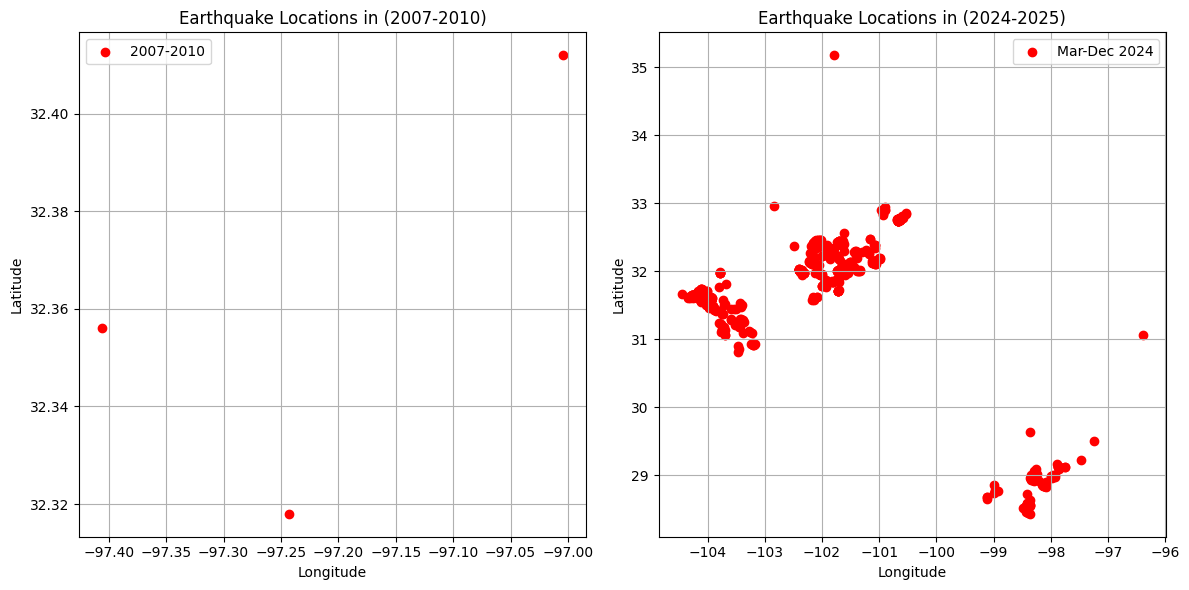

In [70]:
import datetime, json, requests
from pprint import pprint
import matplotlib.pyplot as plt
import pyproj

param1 = { "format": "geojson", "starttime": "2007-01-01","limit": 20000, "endtime": "2010-01-01", "minmagnitude": 1}
param2 = { "format": "geojson", "starttime": "2024-03-01","limit": 20000, "endtime": "2024-12-01", "minmagnitude": 1}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

response1 = requests.get(url, params=param1)
response2 = requests.get(url, params=param2)
data1 = json.loads(response1.text)
data2 = json.loads(response2.text)

quake_data1 = [
  Earthquake(
  Mag=feature['properties']['mag'],
  Place=feature['properties']['place'],
  Time=datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000),
  Lat=feature['geometry']['coordinates'][1],
  Long=feature['geometry']['coordinates'][0],
  Depth=feature['geometry']['coordinates'][2]
  )

  for feature in data1['features']
  if feature['geometry']['coordinates'][2] < 10 and "Texas" in feature['properties']['place']
]

quake_data2 = [
  Earthquake(
  Mag=feature['properties']['mag'],
  Place=feature['properties']['place'],
  Time= datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000),
  Lat=feature['geometry']['coordinates'][1],
  Long=feature['geometry']['coordinates'][0],
  Depth=feature['geometry']['coordinates'][2]
  )
  for feature in data2['features']
  if feature['geometry']['coordinates'][2] < 10 and "Texas" in feature['properties']['place']
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter([eq.Long for eq in quake_data1], [eq.Lat for eq in quake_data1], color='red', label='2007-2010')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Earthquake Locations in (2007-2010)')
ax1.grid(True)
ax1.legend()

ax2.scatter([eq.Long for eq in quake_data2], [eq.Lat for eq in quake_data2], color='Red', label='Mar-Dec 2024' )
ax2.set_xlabel('Longitude')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Earthquake Locations in (2024-2025)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [79]:
import pandas as pd
import pyproj
from dataclasses import dataclass
import datetime

file_path = '/content/drive/MyDrive/Fracking.csv'
fracking_df = pd.read_csv(file_path)

@dataclass
class FrackingData:
  DisclosureId: str
  JobStartDate: datetime.datetime
  JobEndDate: datetime.datetime
  StateName: str
  CountyName: str
  Latitude: float
  Longitude: float
  TVD_Km: float
  TotalBaseWaterVolume: float


  def __init__(self, DisclosureId, JobStartDate, JobEndDate, StateName, CountyName, Latitude, Longitude, TVD_Km, TotalBaseWaterVolume):
    self.DisclosureId = DisclosureId
    self.StateName = StateName
    self.CountyName = CountyName
    self.Latitude = Latitude
    self.Longitude = Longitude
    self.TVD_Km = TVD_Km
    self.TotalBaseWaterVolume = TotalBaseWaterVolume

    # Coordinate transformation
    source_crs = 'epsg:4269'  # NAD83
    target_crs = 'epsg:4326'  # WGS84
    transformer = pyproj.Transformer.from_crs(source_crs, target_crs)
    self.Latitude_WGS84, self.Longitude_WGS84 = transformer.transform(self.Latitude, self.Longitude)

    # Convert dates to datetime objects
    self.JobStartDate = pd.to_datetime(JobStartDate)
    self.JobEndDate = pd.to_datetime(JobEndDate)

# Create a list of FrackingData objects
fracking_data_list = []
for index, row in fracking_df.iterrows():
    # Create a dictionary with the required keys and values from the row
    data_dict = {
        'DisclosureId': row['DisclosureId'],
        'JobStartDate': row['JobStartDate'],
        'JobEndDate': row['JobEndDate'],
        'StateName': row['StateName'],
        'CountyName': row['CountyName'],
        'Latitude': row['Latitude'],
        'Longitude': row['Longitude'],
        'TVD_Km': row['TVD(Km)'],
        'TotalBaseWaterVolume': row['TotalBaseWaterVolume']
    }
    # Create a FrackingData object using the dictionary and add it to the list
    fracking_data_list.append(FrackingData(**data_dict))

# Print job start and end dates
for fracking_data in fracking_data_list:
    print(f"JobStartDate: {fracking_data.JobStartDate}, JobEndDate: {fracking_data.JobEndDate}")

JobStartDate: 2025-01-02 00:00:00, JobEndDate: 2025-01-18 00:00:00
JobStartDate: 2025-01-02 00:00:00, JobEndDate: 2025-01-18 00:00:00
JobStartDate: 2025-01-02 00:00:00, JobEndDate: 2025-01-18 00:00:00
JobStartDate: 2025-01-03 00:00:00, JobEndDate: 2025-01-15 00:00:00
JobStartDate: 2025-01-03 00:00:00, JobEndDate: 2025-01-15 00:00:00
JobStartDate: 2025-01-08 00:00:00, JobEndDate: 2025-01-20 00:00:00
JobStartDate: 2024-10-12 00:00:00, JobEndDate: 2024-10-19 00:00:00
JobStartDate: 2024-10-13 04:03:51, JobEndDate: 2024-10-20 19:16:53
JobStartDate: 2024-10-14 23:38:59, JobEndDate: 2024-10-30 05:57:23
JobStartDate: 2024-10-14 20:10:46, JobEndDate: 2024-10-29 07:33:30
JobStartDate: 2024-10-02 23:11:32, JobEndDate: 2024-10-11 15:50:00
JobStartDate: 2024-10-31 00:00:00, JobEndDate: 2024-11-14 00:00:00
JobStartDate: 2024-10-31 00:00:00, JobEndDate: 2024-11-14 00:00:00
JobStartDate: 2024-10-31 00:00:00, JobEndDate: 2024-11-14 00:00:00
JobStartDate: 2024-11-20 00:00:00, JobEndDate: 2024-11-29 00:0

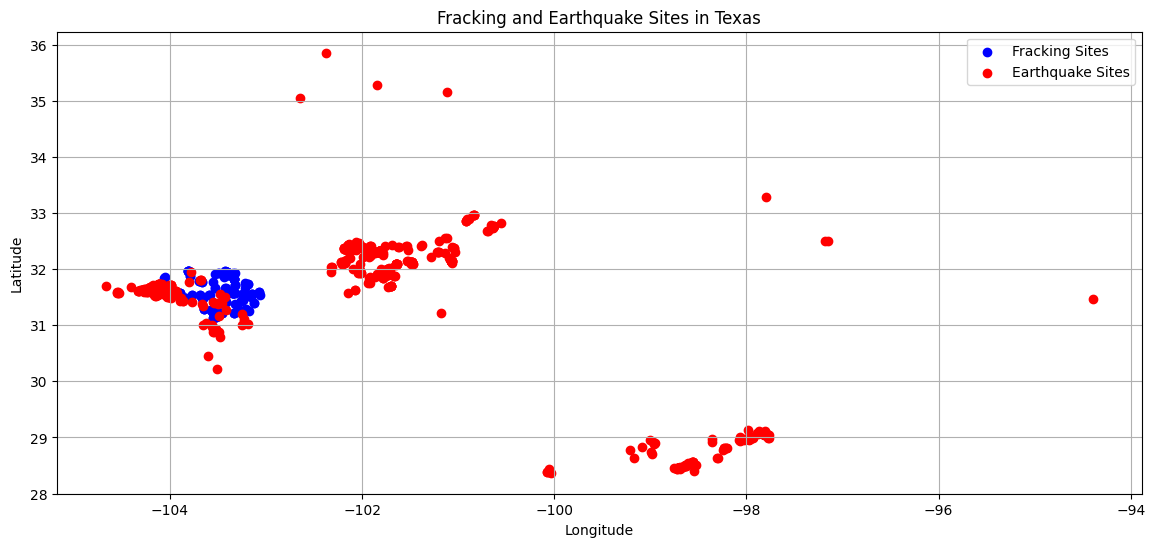

In [72]:
import matplotlib.pyplot as plt

frac_lats = [site.Latitude_WGS84 for site in fracking_data_list]
frac_lons = [site.Longitude_WGS84 for site in fracking_data_list]


eq_lats = [eq.Lat for eq in earthquake_data]
eq_lons = [eq.Long for eq in earthquake_data]

plt.figure(figsize=(14, 6))


plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')

plt.scatter(eq_lons, eq_lats, color='red', label='Earthquake Sites')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking and Earthquake Sites in Texas')
plt.grid(True)
plt.legend()
plt.show()

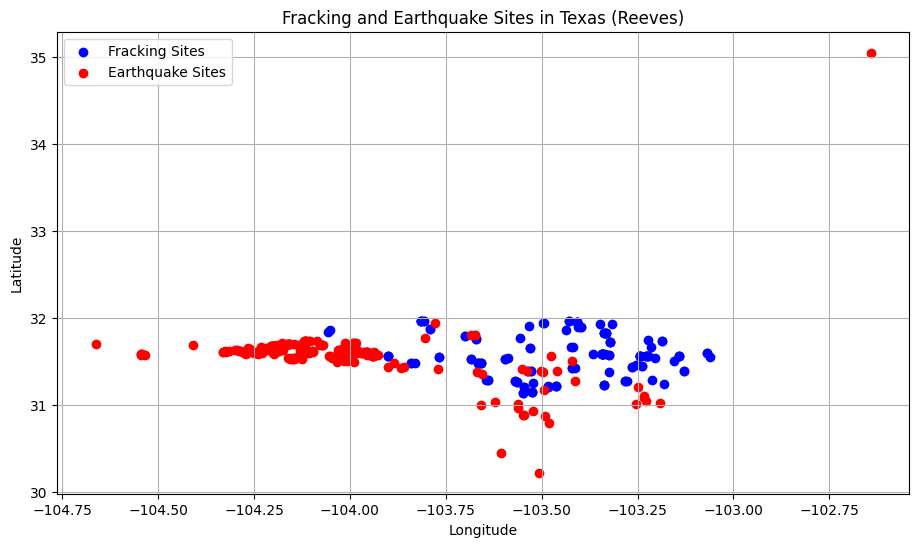

In [73]:
filtered_earthquake_data = [eq for eq in earthquake_data if eq.Long < -102.5]

import matplotlib.pyplot as plt

frac_lats = [site.Latitude_WGS84 for site in fracking_data_list]
frac_lons = [site.Longitude_WGS84 for site in fracking_data_list]


eq_lats = [eq.Lat for eq in filtered_earthquake_data]
eq_lons = [eq.Long for eq in filtered_earthquake_data]

plt.figure(figsize=(11, 6))
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')
plt.scatter(eq_lons, eq_lats, color='red', label='Earthquake Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking and Earthquake Sites in Texas (Reeves)')
plt.grid(True)
plt.legend()
plt.show()

In [74]:
import networkx as nx
import plotly.graph_objects as go
from geopy.distance import geodesic
import matplotlib.pyplot as plt

frac_site = fracking_data_list[49]
frac_site_surface_coords = (frac_site.Latitude_WGS84, frac_site.Longitude_WGS84, 0)  # Surface coordinates (z=0)
frac_site_depth_coords = (frac_site.Latitude_WGS84, frac_site.Longitude_WGS84, frac_site.TVD_Km)


graph = nx.Graph()
graph.add_node("Fracking Site (Surface)", pos=frac_site_surface_coords)

graph.add_node("Fracking Depth", pos=frac_site_depth_coords)

graph.add_edge("Fracking Site (Surface)", "Fracking Depth")

for eq in earthquake_data:
    eq_coords = (eq.Lat, eq.Long, 0)  # Earthquake surface coordinates (z=0)
    graph.add_node(f"Earthquake Site {eq.Place}", pos=eq_coords)

# Get node positions and invert z-coordinates
pos = nx.get_node_attributes(graph, 'pos')
for node, coords in pos.items():
    pos[node] = (coords[0], coords[1], -coords[2])

# Get earthquake magnitudes and create color scale
eq_magnitudes = [eq.Mag for eq in earthquake_data if f"Earthquake Site {eq.Place}" in graph.nodes()]
color_scale = plt.cm.get_cmap('viridis', len(eq_magnitudes))

# Create Plotly traces for nodes and edges
node_trace = go.Scatter3d(
    x=[pos[node][0] for node in graph.nodes()],
    y=[pos[node][1] for node in graph.nodes()],
    z=[pos[node][2] for node in graph.nodes()],
    mode='markers',
    marker=dict(
        size=5,
        color=[color_scale(i) if 'Earthquake Site' in node else 'blue' for i, node in enumerate(graph.nodes())],
        colorscale='Viridis',
        colorbar=dict(title='Magnitude')
    ),
    text=list(graph.nodes()),
    hoverinfo='text'
)

edge_trace = go.Scatter3d(
    x=[], y=[], z=[],
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
)

for edge in graph.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
    edge_trace['z'] += tuple([z0, z1, None])

# Create the Plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Fracking Site, Depth, and Nearby Earthquake (3D Movable)",
                    scene=dict(
                        xaxis_title="Longitude",
                        yaxis_title="Latitude",
                        zaxis_title="Depth (km)",
                        xaxis=dict(  # X-axis background color
                            backgroundcolor="rgb(200, 200, 230)",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white"
                        ),
                        yaxis=dict(  # Y-axis background color
                            backgroundcolor="rgb(230, 200, 230)",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white"
                        ),
                        zaxis=dict(  # Z-axis background color
                            backgroundcolor="rgb(230, 230, 200)",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white"
                        )
                        # aspectratio=dict(x=1, y=1, z=0.7),
                        # camera=dict(
                        #     eye=dict(x=1.4, y=1.4, z=1.25)
                        # )
                    ),
                    showlegend=True,
                )
                )


fig.show()

<ipython-input-74-423372c4dc66>:29: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [75]:
import networkx as nx
import plotly.graph_objects as go
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Assuming you have 'fracking_data_list' and 'earthquake_data' loaded

# Choose a specific fracking site (e.g., the 50th one, using index 49)
frac_site = fracking_data_list[49]
frac_site_surface_coords = (frac_site.Latitude_WGS84, frac_site.Longitude_WGS84, 0)  # Surface coordinates (z=0)
frac_site_depth_coords = (frac_site.Latitude_WGS84, frac_site.Longitude_WGS84, frac_site.TVD_Km)

# Create a graph
graph = nx.Graph()

# Add the fracking site (surface) as a node
graph.add_node("Fracking Site (Surface)", pos=frac_site_surface_coords)

# Add the fracking depth as a node
graph.add_node("Fracking Depth", pos=frac_site_depth_coords)

# Connect the fracking site (surface) to the fracking depth
graph.add_edge("Fracking Site (Surface)", "Fracking Depth")

# Add earthquake site nodes and connect if within radius
radius = 20  # 20 km radius
for eq in earthquake_data:
    eq_coords = (eq.Lat, eq.Long, 0)  # Earthquake surface coordinates (z=0)
    distance_to_frac_site = geodesic(frac_site_surface_coords[:2], eq_coords[:2]).kilometers  # Calculate horizontal distance

    if distance_to_frac_site <= radius:
        graph.add_node(f"Earthquake Site {eq.Place}", pos=eq_coords)
        graph.add_edge("Fracking Site (Surface)", f"Earthquake Site {eq.Place}")  # Connect if within radius

# Get node positions and invert z-coordinates
pos = nx.get_node_attributes(graph, 'pos')
for node, coords in pos.items():
    pos[node] = (coords[0], coords[1], -coords[2])

# Get earthquake magnitudes and create color scale
eq_magnitudes = [eq.Mag for eq in earthquake_data if f"Earthquake Site {eq.Place}" in graph.nodes()]
color_scale = plt.cm.get_cmap('viridis', len(eq_magnitudes))

# Create Plotly traces for nodes and edges
node_trace = go.Scatter3d(
    x=[pos[node][0] for node in graph.nodes()],
    y=[pos[node][1] for node in graph.nodes()],
    z=[pos[node][2] for node in graph.nodes()],
    mode='markers',
    marker=dict(
        size=5,
        color=[color_scale(i) if 'Earthquake Site' in node else 'blue' for i, node in enumerate(graph.nodes())],
        colorscale='Viridis',
        colorbar=dict(title='Magnitude')
    ),
    text=list(graph.nodes()),
    hoverinfo='text'
)

edge_trace = go.Scatter3d(
    x=[], y=[], z=[],
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
)

for edge in graph.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
    edge_trace['z'] += tuple([z0, z1, None])

# Create the Plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Fracking Site, Depth, and Nearby Earthquakes within 20km Radius (3D Movable)",
                    scene=dict(
                        xaxis_title="Longitude",
                        yaxis_title="Latitude",
                        zaxis_title="Depth (km)"
                    ),
                    showlegend=True
                )
                )

fig.show()

<ipython-input-75-d5cb1a6425d6>:42: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



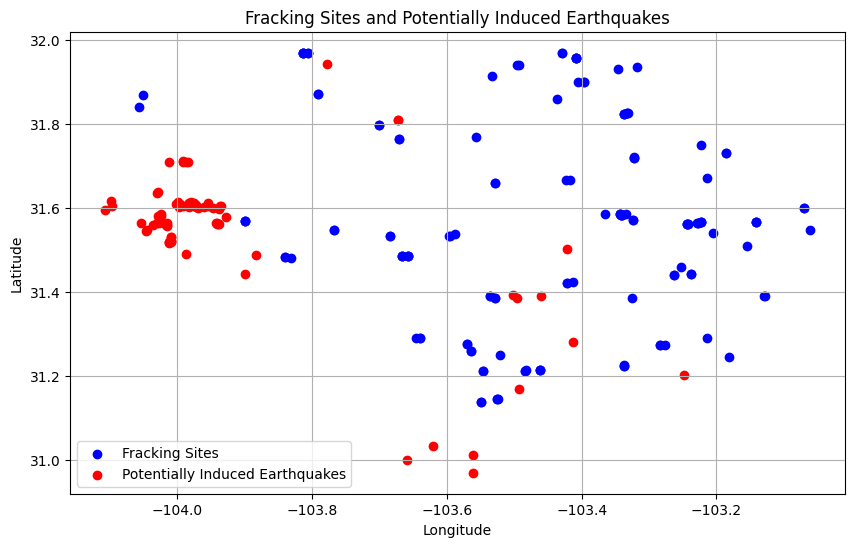

In [76]:
import datetime
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# ... (FrackingData and Earthquake class definitions from previous responses) ...

# Spatial and temporal correlation analysis
radius_km = 20  # Set the radius for spatial proximity
time_window_days = 30  # Set the time window for temporal proximity

potentially_induced_earthquakes = []
for eq in earthquake_data:
    for frac_site in fracking_data_list:
        # Spatial check: Calculate distance and filter
        distance = geodesic((frac_site.Latitude_WGS84, frac_site.Longitude_WGS84),
                            (eq.Lat, eq.Long)).kilometers
        if distance <= radius_km:
            # Temporal check: Check if within time window
            if frac_site.JobStartDate - datetime.timedelta(days=1) <= eq.Time <= frac_site.JobEndDate + datetime.timedelta(days=time_window_days-1):
                potentially_induced_earthquakes.append(eq)
                break  # Move to the next earthquake if found near a site within the time window


frac_lats = [site.Latitude_WGS84 for site in fracking_data_list]
frac_lons = [site.Longitude_WGS84 for site in fracking_data_list]

induced_eq_lats = [eq.Lat for eq in potentially_induced_earthquakes]
induced_eq_lons = [eq.Long for eq in potentially_induced_earthquakes]

plt.figure(figsize=(10, 6))
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')
plt.scatter(induced_eq_lons, induced_eq_lats, color='red', label='Potentially Induced Earthquakes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking Sites and Potentially Induced Earthquakes')
plt.grid(True)
plt.legend()
plt.show()